In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns

In [2]:
def data_preprocessing(train_data, test_data):
    # Normalize data
    train_data_normalized = (train_data - train_data.mean()) / train_data.std()
    test_data_normalized = (test_data - test_data.mean()) / test_data.std()
    
    return train_data_normalized, test_data_normalized

In [3]:
train_data = pd.read_csv('/Users/hetvishukla/Deep learning/project/fashion MNIST/fashion-mnist_train.csv')
test_data =  pd.read_csv('/Users/hetvishukla/Deep learning/project/fashion MNIST/fashion-mnist_test.csv')


In [4]:
train_labels = train_data['label']
train_data.drop('label', axis=1, inplace=True)
test_labels = test_data['label']
test_data.drop('label', axis=1, inplace=True)

train_preprocess, test_preprocess = data_preprocessing(train_data, test_data)

combined_data = pd.concat([train_preprocess, train_preprocess], axis=0)

In [5]:
train_tensor = torch.tensor(train_data.values, dtype=torch.float32)
test_tensor =  torch.tensor(test_data.values, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels.values)
test_labels_tensor = torch.tensor(test_labels.values)

train_labels.describe()

print("Train images shape:", train_tensor.shape)
print("Train labels length:", len(train_labels_tensor))
print("Test images shape:", test_tensor.shape)
print("Test labels length:", len(test_labels_tensor))


# Define class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 
               'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# data_analysis(combined_data)

Train images shape: torch.Size([60000, 784])
Train labels length: 60000
Test images shape: torch.Size([10000, 784])
Test labels length: 10000


In [6]:
def train_model_with_cv(model, criterion, optimizer, train_loader, test_loader, num_epochs=100):
    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []
    for epoch in range(num_epochs):
        running_train_loss = 0.0
        running_train_corrects = 0
        running_test_loss = 0.0
        running_test_corrects = 0
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            running_train_corrects += torch.sum(preds == labels.data)

        epoch_train_loss = running_train_loss / len(train_loader)
        train_losses.append(epoch_train_loss)
        epoch_train_acc = running_train_corrects.double() / len(train_loader.dataset)
        train_accs.append(epoch_train_acc)

        model.eval()
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item()
                running_test_corrects += torch.sum(preds == labels.data)

        epoch_test_loss = running_test_loss / len(test_loader)
        test_losses.append(epoch_test_loss)
        epoch_test_acc = running_test_corrects.double() / len(test_loader.dataset)
        test_accs.append(epoch_test_acc)

        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, '
              f'Test Loss: {epoch_test_loss:.4f}, Test Acc: {epoch_test_acc:.4f}')

    return train_losses, test_losses, train_accs, test_accs

In [7]:
# ANN model with batch normalization
class ANN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


In [8]:
def senario():
    # Define configurations to compare
    hidden_sizes = [64, 128, 256]  # Vary the hidden layer sizes
    
    # Define k-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True)
    
    results = []
    
    for hidden_size in hidden_sizes:
        fold_results = []
        
        for fold, (train_index, test_index) in enumerate(kf.split(train_tensor), 1):
            print(f"\nFold {fold}, Hidden Size {hidden_size}")
            train_data_fold, val_data_fold = train_tensor[train_index], train_tensor[test_index]
            train_labels_fold, val_labels_fold = train_labels_tensor[train_index], train_labels_tensor[test_index]

            # Initialize ANN model with current hidden size
            model = ANN(train_tensor.shape[1], hidden_size, 10)

            # Loss function and optimizer
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.SGD(model.parameters(), lr=0.01)

            # Convert to DataLoader
            train_dataset = torch.utils.data.TensorDataset(train_data_fold, train_labels_fold)
            train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
            val_dataset = torch.utils.data.TensorDataset(val_data_fold, val_labels_fold)
            val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

            # Train the model with k-fold cross-validation
            train_losses, test_losses, train_accs, test_accs = train_model_with_cv(model, criterion, optimizer,
                                                                                 train_loader, val_loader, num_epochs=10)

            # Store results
            fold_results.append({
                'hidden_size': hidden_size,
                'train_losses': train_losses,
                'test_losses': test_losses,
                'train_accs': train_accs,
                'test_accs': test_accs
            })
        
        results.append(fold_results)
    
    return results



Fold 1, Hidden Size 64
Epoch [1/10], Train Loss: 0.7817, Train Acc: 0.7749, Test Loss: 0.5441, Test Acc: 0.8208
Epoch [2/10], Train Loss: 0.5045, Train Acc: 0.8339, Test Loss: 0.4620, Test Acc: 0.8428
Epoch [3/10], Train Loss: 0.4491, Train Acc: 0.8478, Test Loss: 0.4316, Test Acc: 0.8546
Epoch [4/10], Train Loss: 0.4187, Train Acc: 0.8558, Test Loss: 0.4143, Test Acc: 0.8595
Epoch [5/10], Train Loss: 0.3973, Train Acc: 0.8621, Test Loss: 0.4189, Test Acc: 0.8538
Epoch [6/10], Train Loss: 0.3810, Train Acc: 0.8690, Test Loss: 0.4077, Test Acc: 0.8585
Epoch [7/10], Train Loss: 0.3690, Train Acc: 0.8719, Test Loss: 0.3782, Test Acc: 0.8688
Epoch [8/10], Train Loss: 0.3554, Train Acc: 0.8744, Test Loss: 0.3807, Test Acc: 0.8653
Epoch [9/10], Train Loss: 0.3451, Train Acc: 0.8791, Test Loss: 0.3801, Test Acc: 0.8681
Epoch [10/10], Train Loss: 0.3359, Train Acc: 0.8814, Test Loss: 0.3750, Test Acc: 0.8674

Fold 2, Hidden Size 64
Epoch [1/10], Train Loss: 0.7903, Train Acc: 0.7736, Test Los

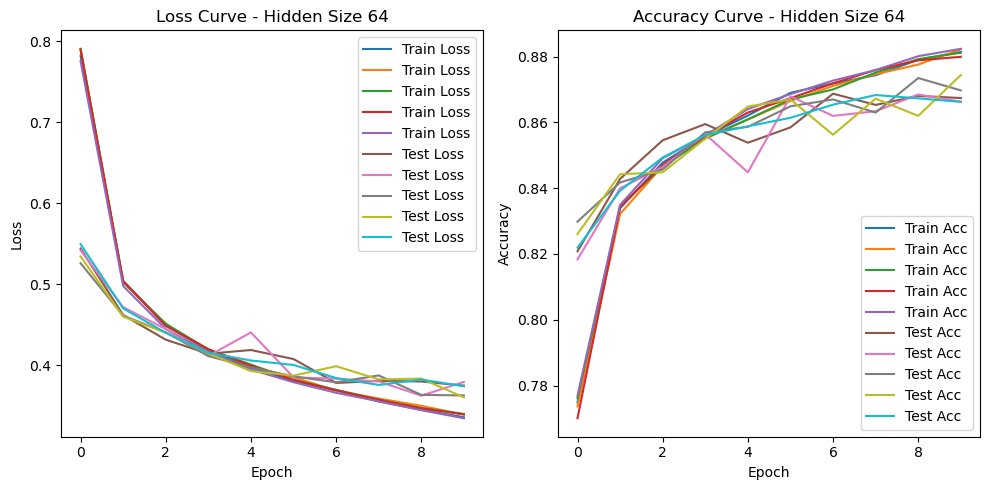

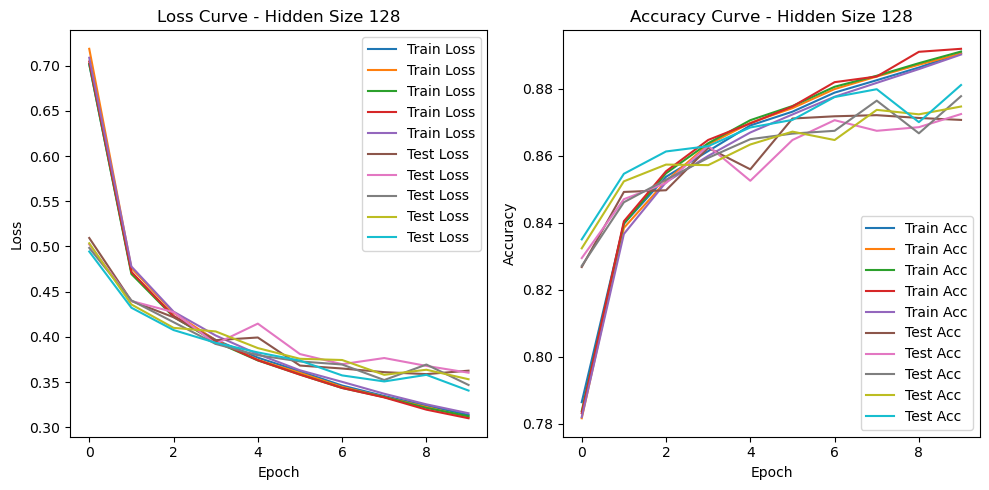

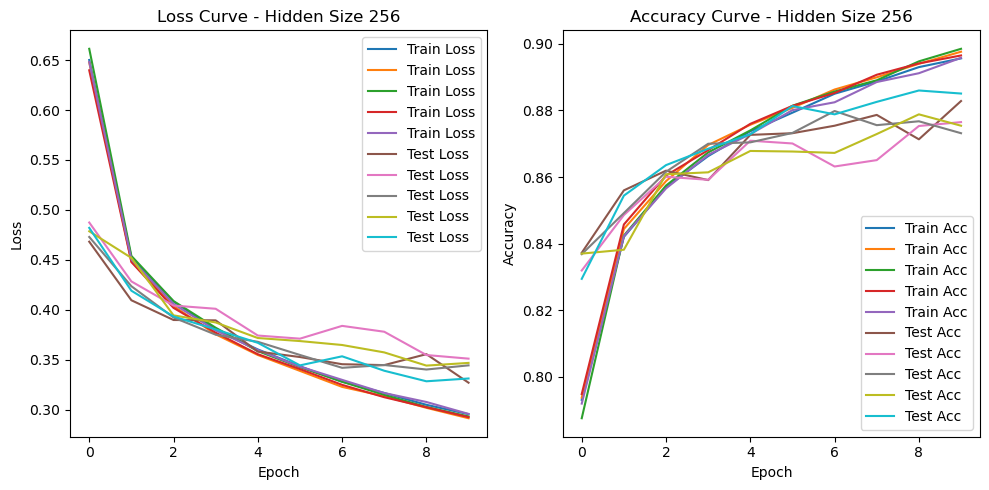

In [9]:
results = senario()
for fold_results in results:
    hidden_size = fold_results[0]['hidden_size']
    train_losses_all_folds = [fold['train_losses'] for fold in fold_results]
    test_losses_all_folds = [fold['test_losses'] for fold in fold_results]
    train_accs_all_folds = [fold['train_accs'] for fold in fold_results]
    test_accs_all_folds = [fold['test_accs'] for fold in fold_results]
    
    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    for train_losses in train_losses_all_folds:
        plt.plot(train_losses, label='Train Loss')
    for test_losses in test_losses_all_folds:
        plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss Curve - Hidden Size {hidden_size}')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    for train_accs in train_accs_all_folds:
        plt.plot(train_accs, label='Train Acc')
    for test_accs in test_accs_all_folds:
        plt.plot(test_accs, label='Test Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy Curve - Hidden Size {hidden_size}')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [10]:
for fold_results in results:
    for fold in fold_results:
        hidden_size = fold['hidden_size']
        test_losses = fold['test_losses'][-1]  # Final test loss
        test_accs = fold['test_accs'][-1]  # Final test accuracy
        
        print(f"Hidden Layer Size: {hidden_size}, Final Test Loss: {test_losses:.4f}, Final Test Accuracy: {test_accs:.4f}")


Hidden Layer Size: 64, Final Test Loss: 0.3750, Final Test Accuracy: 0.8674
Hidden Layer Size: 64, Final Test Loss: 0.3796, Final Test Accuracy: 0.8663
Hidden Layer Size: 64, Final Test Loss: 0.3629, Final Test Accuracy: 0.8698
Hidden Layer Size: 64, Final Test Loss: 0.3605, Final Test Accuracy: 0.8744
Hidden Layer Size: 64, Final Test Loss: 0.3742, Final Test Accuracy: 0.8662
Hidden Layer Size: 128, Final Test Loss: 0.3626, Final Test Accuracy: 0.8708
Hidden Layer Size: 128, Final Test Loss: 0.3603, Final Test Accuracy: 0.8725
Hidden Layer Size: 128, Final Test Loss: 0.3467, Final Test Accuracy: 0.8778
Hidden Layer Size: 128, Final Test Loss: 0.3531, Final Test Accuracy: 0.8748
Hidden Layer Size: 128, Final Test Loss: 0.3405, Final Test Accuracy: 0.8812
Hidden Layer Size: 256, Final Test Loss: 0.3271, Final Test Accuracy: 0.8828
Hidden Layer Size: 256, Final Test Loss: 0.3511, Final Test Accuracy: 0.8765
Hidden Layer Size: 256, Final Test Loss: 0.3444, Final Test Accuracy: 0.8732
Hidd